# Car Price prediction

![cars](http://1.bp.blogspot.com/-Iq9Y1Ex6M8I/VkpRygq69EI/AAAAAAAAD6o/SaUWI7QtPqk/s1600/Audi-RS-5-BMW-M3-Mercedes-C-63-AMG-1200x800-731268a2f334fcee%2B%25281%2529.jpg)

## Прогнозирование стоимости автомобиля по характеристикам
Необходимо построить модель, которая будет распознавать изображения и обрабатывать текст.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re
import seaborn as sns



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression, mutual_info_regression


# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pd.set_option('display.max_rows', 50)  
pd.set_option('display.max_columns', 50)

# определяем функции

'''функция для подсчета пропущенных значений и их процента от общего числа значений'''


def missing_table(df):
    mis_val = df.isnull().sum()
    percent = 100 * df.isnull().sum() / len(df)
    mis_table = pd.DataFrame({
        'Missing Values': mis_val,
        '% of Total Values': percent
    })
    return mis_table



'''функция, выводящая средние показатели: mean, median, mode'''


def mid_val(df, column):
    median = df[column].median()
    mode = df[column].mode()
    mean = df[column].mean()
    return display(
        pd.DataFrame({
            'Признак': column,
            'Медиана': median,
            'Среднее': mean,
            'Мода': mode
        }))



'''функция, выводящая все уникальные значения и их количество'''


def cat_values(df, column):
    display(pd.DataFrame(df[column].value_counts(dropna=True)))
    s = sns.catplot(x=column, kind="count", palette="Blues", data=df)
    s.set_xticklabels(rotation=90)


    
'''функция для вывода краткой описательной статистики'''


def desc_stat(df, column):
    minimum = df[column].min()
    maximum = df[column].max()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    print(
        'Минимальное значение: {}'.format(minimum),
        '\nМаксимальное значение: {}'.format(maximum),
        '\n25-й перцентиль: {}'.format(perc25),
        '\n75-й перцентиль: {}'.format(perc75), '\nIQR: {}'.format(IQR),
        '\nГраницы выбросов: [{f}, {l}]'.format(f=perc25 - 1.5 * IQR,
                                                l=perc75 + 1.5 * IQR))


'''функция, определяющая границы выбросов'''


def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [5, 95])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound



'''функция для опеределения средней стоимости автомобиля по категориям признака'''


def mean_price_by(df, column):
    return df.groupby([column])[['price'
                                    ]].mean().sort_values(['price'],
                                                          ascending=False)


'''функция, определяющая распределение средней стоимости автомобиля относительно его возраста'''


def price_by(df, column):
    return df.groupby(
        df[column])['price'].mean().to_frame().reset_index().sort_values(
            by=[column]).plot.line(x=column, y='price')


'''функция для построения графика зависимости от целевого признака'''


def price_plot(df, column):
    return sns.lmplot(x=column,
                      y="price",
                      data=df,
                      markers=["o"],
                      palette="Set1")


'''функция, определяющая среднюю абсолютную ошибку в процентах'''


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))


from sklearn.metrics import make_scorer
# отмечаем функцию для скоринга
mape_score = make_scorer(mape, greater_is_better=False)


# функция для указания возраста автомобиля


def ownership_length(row):
    y_list = ['лет', 'год']
    m_list = ['месяцев','месяца']
    months = []
    if 'указано' in row:
        return row
    else:
        row_list = row.split()
        for i in row_list:
            if i in y_list:
                index = row_list.index(i)
                months.append(12*int(row_list[index-1]))
            elif i in m_list:
                index = row_list.index(i)
                months.append(int(row_list[index-1]))
                return str(sum(months))


In [3]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5


In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [9]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [10]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [11]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

In [12]:
ttrain = train.copy()

In [13]:
ttrain.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,530xi 3.0 AT (272 л.с.) 4WD,4,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,2.8 CVT (204 л.с.),4,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,350 3.5 AT (306 л.с.) 4WD,4,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,2.0 CVT (180 л.с.),4,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,1.8 CVT (160 л.с.),5,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


In [14]:
ttrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

Большая часть признаков - категориальные.  
Проверим все переменные и после расставим по видам

In [15]:
missing_table(ttrain)

,Missing Values,% of Total Values
bodyType,0,0.000000
brand,0,0.000000
color,0,0.000000
description,0,0.000000
engineDisplacement,0,0.000000
enginePower,0,0.000000
fuelType,0,0.000000
mileage,0,0.000000
modelDate,0,0.000000
model_info,0,0.000000


Пропущенные значения замечены только в двух признаках, однако у нас они могут маскироваться под повторяющиеся строки, проверим
А сейчас проверим датасет на наличие дубликатов

In [16]:
ttrain['sell_id'].nunique() == len(ttrain)

True

Дубликатов нет, просмотрим целевую переменную и после пойдем по порядку

## price

C:\Users\assem\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

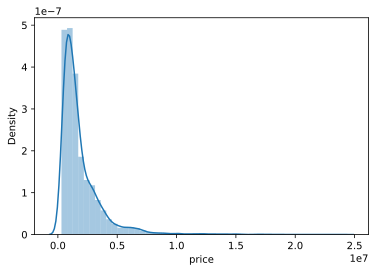

In [17]:
sns.distplot(ttrain['price'])

<AxesSubplot:xlabel='price'>

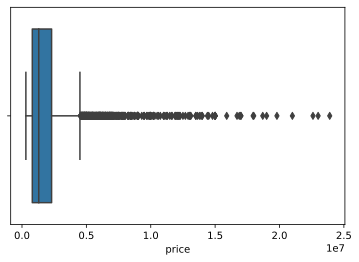

In [18]:
sns.boxplot(x=ttrain['price'])

Распределение логнормальное, выбросов много

## bodyType

,bodyType
седан,2843
внедорожник 5 дв.,2315
купе,427
хэтчбек 5 дв.,296
лифтбек,245
универсал 5 дв.,153
минивэн,146
купе-хардтоп,91
родстер,60
кабриолет,44


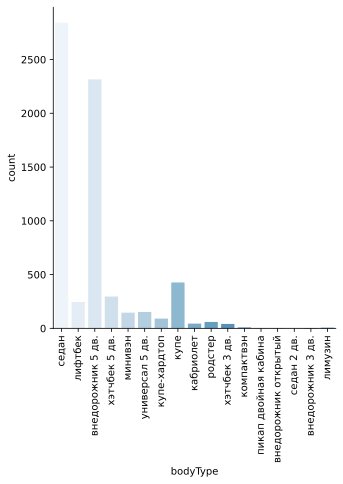

In [19]:
cat_values(ttrain, 'bodyType')

In [20]:
mean_price_by(ttrain, 'bodyType')

,price
bodyType,
лимузин,3.580000e+06
пикап двойная кабина,3.449500e+06
минивэн,3.328060e+06
родстер,2.670411e+06
купе,2.402312e+06
кабриолет,2.377376e+06
внедорожник 5 дв.,2.238908e+06
лифтбек,2.001351e+06
внедорожник открытый,1.910000e+06


Видим, что количество дверей все же влияет на цену ощутимо, тут оставляем всё как есть.

## brand

,brand
BMW,2805
MERCEDES,2294
AUDI,1583


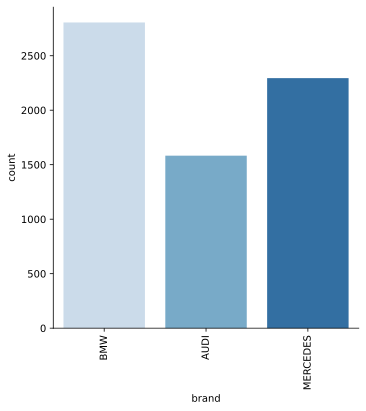

In [21]:
cat_values(ttrain, 'brand')

In [22]:
mean_price_by(ttrain, 'brand')

,price
brand,
MERCEDES,2.580642e+06
BMW,1.718738e+06
AUDI,1.234282e+06


Интересно, в наших данных представлены всего три немецких бренда  
AUDI является аутсайдером и по популярности, и по средней стоимости автомобилей

## color

,color
чёрный,2805
белый,1263
серый,733
синий,685
серебристый,341
коричневый,307
красный,203
бежевый,76
голубой,72
зелёный,70


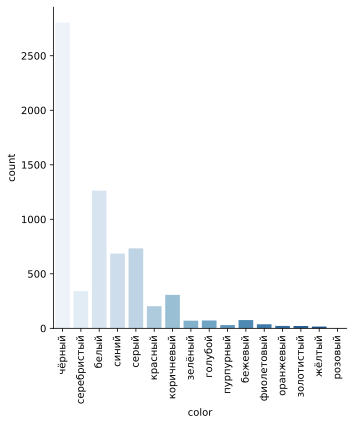

In [23]:
cat_values(ttrain, 'color')

In [24]:
mean_price_by(ttrain,'color')

,price
color,
розовый,4.000000e+06
жёлтый,2.644500e+06
оранжевый,2.196752e+06
чёрный,2.119408e+06
серый,2.082614e+06
синий,1.892083e+06
белый,1.744718e+06
зелёный,1.677552e+06
голубой,1.676432e+06


Интересные результаты, посмотрела:  
гендиректор «Подбор Авто» Денис Еременко: «На нашем рынке все устроено так же: машины ярких цветов стоят в среднем дороже, нежели черные, белые или серые. Но только в том случае, если это не автомобиль из такси, которые часто бывают как раз желтого цвета»

In [25]:
ttrain[ttrain['color'] == 'жёлтый']['price'].mean()

2644500.0

Что ж, в этом случае без сюрпризов согласно мнению эксперта

## description

In [26]:
ttrain['description']

0       Авто на бодром ходу.  Все работает отлично.  П...
1       Продажа от собственника, второй владелец, ПТС ...
2       Внимание! Только для клиентов AVILON Автомобил...
3       В комплекте зимние колёса. 27.07.2020 Замена п...
4       Отличный авто, 2011 года выпуска, кроме передн...
                              ...                        
6677    Продаётся любимый автомобиль! За годы эксплуат...
6678    Куплена у официального дилера в 2017 г. \n\nТр...
6679    Торг на месте. Все работает. Сборка немецкая. ...
6680    Автомобиль в отличном состоянии.\n3-из Авто в ...
6681    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 6682, dtype: object

Тексты объявлений. В прошлой работе я создавала признак, который покажет, явлется ли продавец дилером или нет  
Попробуем сделать то же самое, и проверить влияет ли это на стоимость автомобиля

## engineDisplacement

In [27]:
engine_words = ttrain['engineDisplacement'].apply(lambda x: x.split(' ')[1])
engine_words.value_counts()

LTR    6682
Name: engineDisplacement, dtype: int64

In [28]:
len(engine_words) == len(ttrain)

True

Приставка LTR роли в стоимости цены не играет, можем выкинуть ее, и оставим числовой признак - объем двигателя

## enginePower

In [29]:
engine_p = ttrain['enginePower'].apply(lambda x: x.split(' ')[1])
engine_p.value_counts()

N12    6682
Name: enginePower, dtype: int64

Приставка N12 также везде, избавимся от нее и переведем в формат целых чисел

## fuelType

,fuelType
бензин,4804
дизель,1861
гибрид,12
электро,5


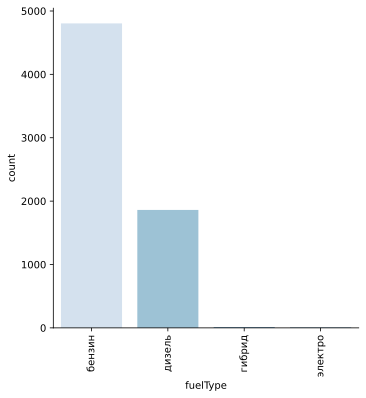

In [30]:
cat_values(ttrain, 'fuelType')

In [31]:
mean_price_by(ttrain, 'fuelType')

,price
fuelType,
гибрид,2.599583e+06
дизель,2.317972e+06
электро,2.133742e+06
бензин,1.735910e+06


Бензин, очевидно, самый популярный, и самый дешевый в среднем

## mileage

<AxesSubplot:xlabel='mileage'>

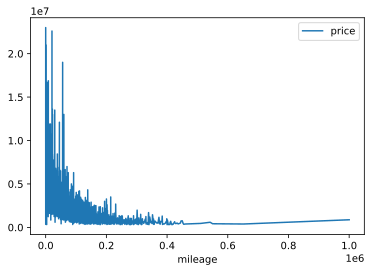

In [32]:
price_by(ttrain,'mileage')

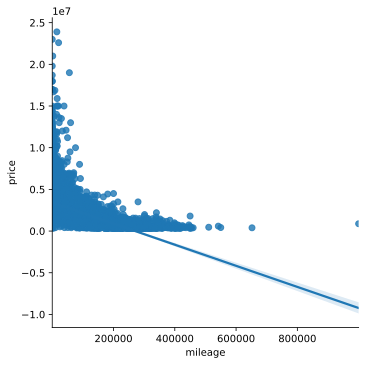

In [33]:
price_plot(ttrain,'mileage')

Тут все без сюрпризов, количество миль обратно пропорционально цене

## modelDate

<AxesSubplot:xlabel='modelDate'>

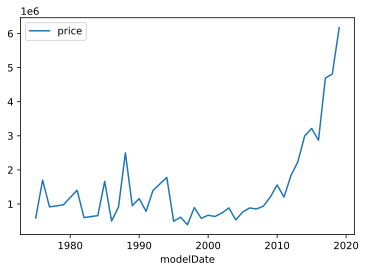

In [34]:
price_by(ttrain, 'modelDate')

Кривая неровная, видимо, среди старых моделей есть коллекционные, но зависимость явно прямая

## model_info

In [35]:
ttrain['model_info'].value_counts()

5ER           611
3ER           466
E_KLASSE      410
X5            397
A6            358
             ... 
X3_M            1
None            1
M1              1
SLR_KLASSE      1
Z1              1
Name: model_info, Length: 118, dtype: int64

In [36]:
mean_price_by(ttrain, 'model_info')

,price
model_info,
SLR_KLASSE,2.390000e+07
SLS_AMG,1.433980e+07
Z8,1.400000e+07
AMG_GT,8.920538e+06
8ER,7.445913e+06
...,...
A1,6.214762e+05
CITAN,6.000000e+05
CLC_KLASSE,5.116667e+05


Итак, видов моделей в датасете - 118

## name

In [37]:
ttrain['name'].value_counts()

200 2.0 AT (184 л.с.)             121
35i 3.0 AT (306 л.с.) 4WD         116
2.0 AMT (211 л.с.) 4WD            113
30d 3.0d AT (249 л.с.) 4WD         87
400 3.0 AT (333 л.с.) 4WD          76
                                 ... 
328i 2.8 AT (193 л.с.)              1
230 2.3 AT (197 л.с.)               1
735i 3.5 MT (218 л.с.)              1
30i 3.0 AT (258 л.с.)               1
550 Long 5.5 AT (388 л.с.) 4WD      1
Name: name, Length: 900, dtype: int64

Признак названия составной, состоит из объема двигателя, количества лошадиных сил, привода  
Возможно, признак нам будет не нужен

## numberOfDoors

,numberOfDoors
5,3090
4,2923
2,627
3,42


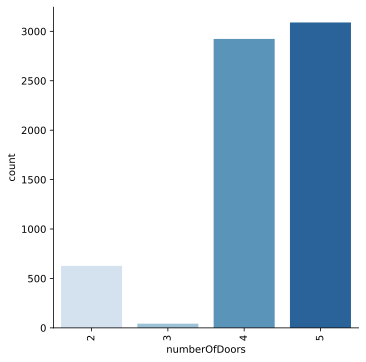

In [38]:
cat_values(ttrain, 'numberOfDoors')

In [39]:
mean_price_by(ttrain, 'numberOfDoors')

,price
numberOfDoors,
2,2.271105e+06
5,2.087515e+06
4,1.640509e+06
3,6.025000e+05


Количество дверей в машине - важный для целевой переменной признак, оставляем без изменений  
Видим, что в среднем самые дорогие машины - двудверные. Это обычно спорткары, тут тоже без сюрпризов

## productionDate

<AxesSubplot:xlabel='productionDate'>

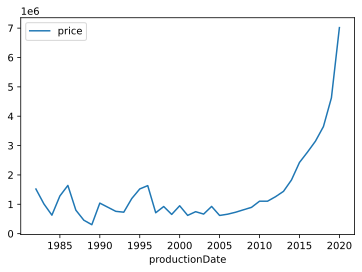

In [40]:
price_by(ttrain, 'productionDate')

В признаке даты производства машины наблюдается схожая картина как и у признака создания модели машины: до 2000-х график скачет, после - видна плавная прямая зависимость новизны машины и ее цены

## vehicleConfiguration

In [41]:
ttrain['vehicleConfiguration']

0           SEDAN AUTOMATIC 3.0
1            SEDAN VARIATOR 2.8
2           SEDAN AUTOMATIC 3.5
3            SEDAN VARIATOR 2.0
4         LIFTBACK VARIATOR 1.8
                 ...           
6677        SEDAN AUTOMATIC 2.0
6678        SEDAN AUTOMATIC 2.0
6679        SEDAN AUTOMATIC 2.0
6680        SEDAN AUTOMATIC 3.0
6681    LIMOUSINE AUTOMATIC 6.0
Name: vehicleConfiguration, Length: 6682, dtype: object

Признак - сбор названия кузова и трансмиссии  
При оценке значимости проверим, нужен ли он нам

## vehicleTransmission

,vehicleTransmission
автоматическая,5261
роботизированная,959
вариатор,325
механическая,137


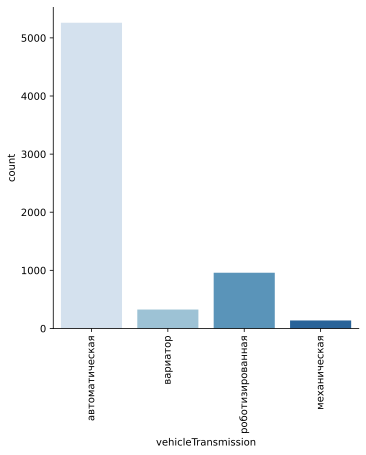

In [42]:
cat_values(ttrain, 'vehicleTransmission')

In [43]:
mean_price_by(ttrain, 'vehicleTransmission')

,price
vehicleTransmission,
автоматическая,2.046799e+06
роботизированная,1.647541e+06
механическая,9.178057e+05
вариатор,6.799364e+05


Автоматическая и роботизированная коробки передач являются лидерами по популярности и средней стоимости автомобиля.  
Влияние на целевую переменную хорошо прослеживается, оставляем без изменений

## Владельцы

,Владельцы
3 или более,2646
1 владелец,2029
2 владельца,2006


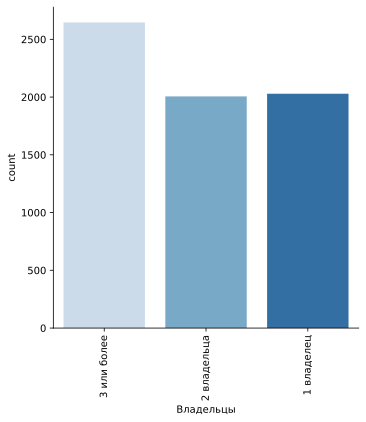

In [44]:
cat_values(ttrain, 'Владельцы')

In [45]:
ttrain[ttrain['Владельцы'].isna() == True]

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
4994,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.2 LTR,360 N12,бензин,160000,1999,S8,4.2 AT (360 л.с.) 4WD,4,600000.0,2001,1019330519,SEDAN AUTOMATIC 4.2,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый


Мы видим, что возраст машины составляет 20 лет, однако в графе "Владение" указан меньший срок. Можем предположить, что эта графа указывает владение последним хозяином.  
Значит, у машины строкой 4994 был точно не один владелец, заменим пропущенное значение самым частым.

In [46]:
ttrain['Владельцы'] = ttrain['Владельцы'].fillna(ttrain['Владельцы'].mode()[0])

In [47]:
ttrain['Владельцы'][1]

'2\xa0владельца'

In [48]:
ttrain[ttrain['Владельцы'] == '2\xa0владельца'][['Владение', 'productionDate']]

,Владение,productionDate
1,8 лет и 6 месяцев,2011
8,NaN,2015
10,NaN,2017
11,5 лет и 7 месяцев,2008
17,NaN,2015
...,...,...
6669,NaN,2016
6670,10 лет и 6 месяцев,2009
6674,13 лет и 5 месяцев,2007
6675,NaN,2012


Для облегчения читабельности попробуем сократить запись лишь на продолжительность владения в месяцах

## Владение

Мы знаем, что в этом признаке 64% пропущенных значений.  
Прежде чем выкинуть весь признак, посмотрим, чем он может быть полезен.

In [49]:
# заполним пропущенные значения другой категорией в признаке "Владение"

ttrain['Владение'] = ttrain['Владение'].fillna('Не указано')

In [50]:
ttrain['Владение'] = ttrain['Владение'].apply(lambda x: ownership_length(x))

In [51]:
mean_price_by(ttrain, 'Владение')

,price
Владение,
141,5.000000e+06
202,5.000000e+06
86,3.568000e+06
65,2.571429e+06
69,2.419800e+06
...,...
196,4.200000e+05
208,4.200000e+05
138,4.000000e+05


Довольно интересные результаты, думаю, объясняются выбросами: 12 летние машины в среднем самые дорогие

Хотелось бы перевести признак в числовой формат, но не вижу какой-то закономерности для замещения определенным значением.  
И пропущенных значений больше половины, указать моду как замену, тоже не вариант.  
Оставлю признак категориальным.

## ПТС

,ПТС
Оригинал,5970
Дубликат,712


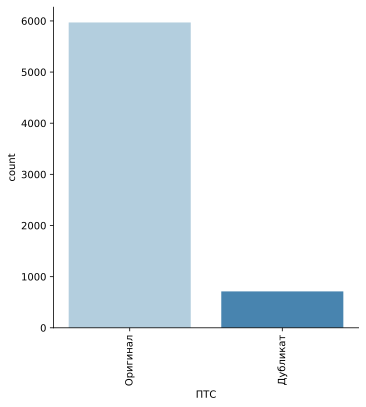

In [52]:
cat_values(ttrain, 'ПТС')

In [53]:
mean_price_by(ttrain, 'ПТС')

,price
ПТС,
Оригинал,1.997736e+06
Дубликат,1.079263e+06


Дубликаты в датасете составляют 10% от количества оригинала ПТС  
Разница средней стоимости между ними почти двукратная

## Привод

,Привод
полный,4189
задний,1790
передний,703


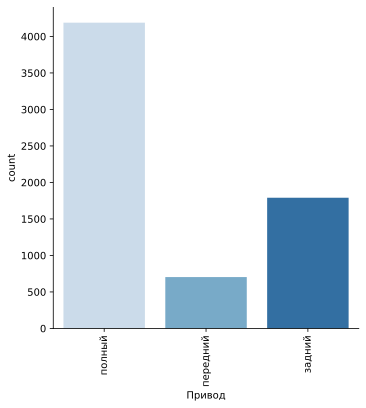

In [54]:
cat_values(ttrain, 'Привод')

In [55]:
mean_price_by(ttrain, 'Привод')

,price
Привод,
полный,2.291359e+06
задний,1.373554e+06
передний,9.071871e+05


Тут таблица рейтингов совпадает как в популярности, так и по средней стоимости: полный привод лидирует, и за ним идут задний и передний

## Руль

,Руль
Левый,6680
Правый,2


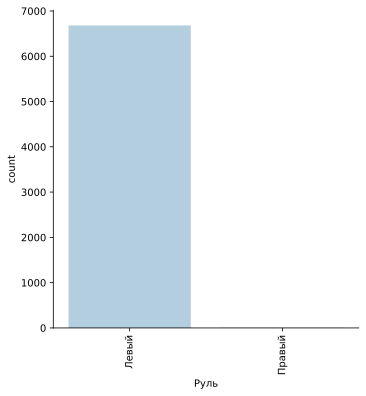

In [56]:
cat_values(ttrain, 'Руль')

In [57]:
mean_price_by(ttrain, 'Руль')

,price
Руль,
Левый,1.900145e+06
Правый,9.750000e+05


Просто чудовищно мало представлено праворульных машин, думаю, этот признак не сильно поможет при построении модели  
UPD: при удалении процент ошибки увеличивается

# Feauture Engineering

## 4WD

Для того, чтобы создать новый признак, нужно найти в столбце name все упоминания 4WD
Проверим заодно, будет ли полезен признак полного привода в отдельном столбце

In [58]:
four_wd = []
for index, row in ttrain['name'].items():
    if '4WD' in row:
        four_wd.append(index)
    
ttrain['4WD'] = 0
for n, i in enumerate(four_wd):
    ttrain.loc[i, '4WD'] = 1    

In [59]:
mean_price_by(ttrain, '4WD')

,price
4WD,
1,2.291359e+06
0,1.242044e+06


Разница в средней цене по наличию полного привода почти двукратная  
UPD признак улучшает точность почти на 0,4%

## engineDisplacement

In [60]:
# Убираем все приставки "LTR", и преобразуем признак в форму вещественных чисел

ttrain['engineDisplacement'] = ttrain['engineDisplacement'].apply(lambda x: x.split(' ')[0])

In [61]:
# Замена объема двигателя электрокаров на 0

ttrain['engineDisplacement'] = ttrain['engineDisplacement'].replace('undefined',0, regex=True)
ttrain['engineDisplacement']=ttrain['engineDisplacement'].astype('float')

<AxesSubplot:xlabel='engineDisplacement'>

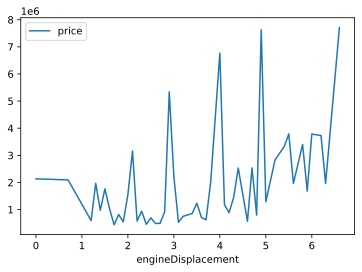

In [62]:
price_by(ttrain, 'engineDisplacement')

Выбросов довольно много, график очень ломаный. Возможно, признак будет не очень полезен

## enginePower

In [63]:
# Приставка N12 также везде, избавимся от нее и переведем в формат целых чисел

ttrain['enginePower'] = ttrain['enginePower'].apply(lambda x: x.split(' ')[0]).astype('int64')

<AxesSubplot:xlabel='enginePower'>

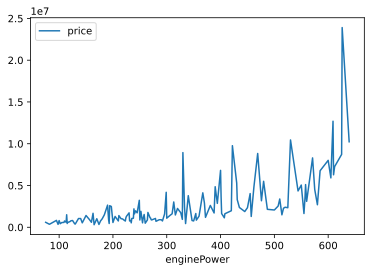

In [64]:
price_by(ttrain, 'enginePower')

Тут также ломанная кривая, но видим, что с увеличением лошадиных сил справедливо растет и цена

# miles_per_year

In [65]:
ttrain['miles_per_year'] = ttrain['mileage'] / (2021 - ttrain['productionDate'])

<AxesSubplot:xlabel='miles_per_year'>

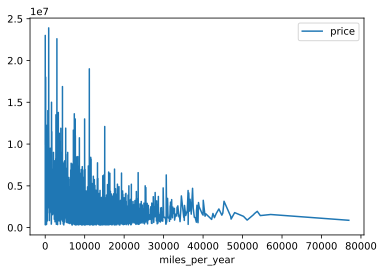

In [66]:
price_by(ttrain, 'miles_per_year')

*Признак негативно повлиял на точность модели  

## vehicle_age

In [67]:
ttrain['vehicle_age'] = 2021 - ttrain['productionDate'] 

<AxesSubplot:xlabel='vehicle_age'>

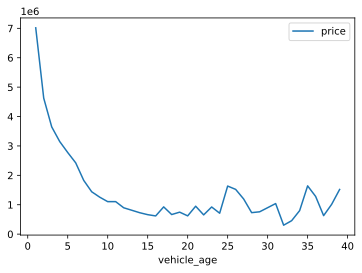

In [68]:
price_by(ttrain, 'vehicle_age')

Видим так же много выбросов, но в целом хорошо отличимую тенденцию: чем выше возраст автомобиля, тем ниже цена.

# Распределение числовых признаков

C:\Users\assem\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


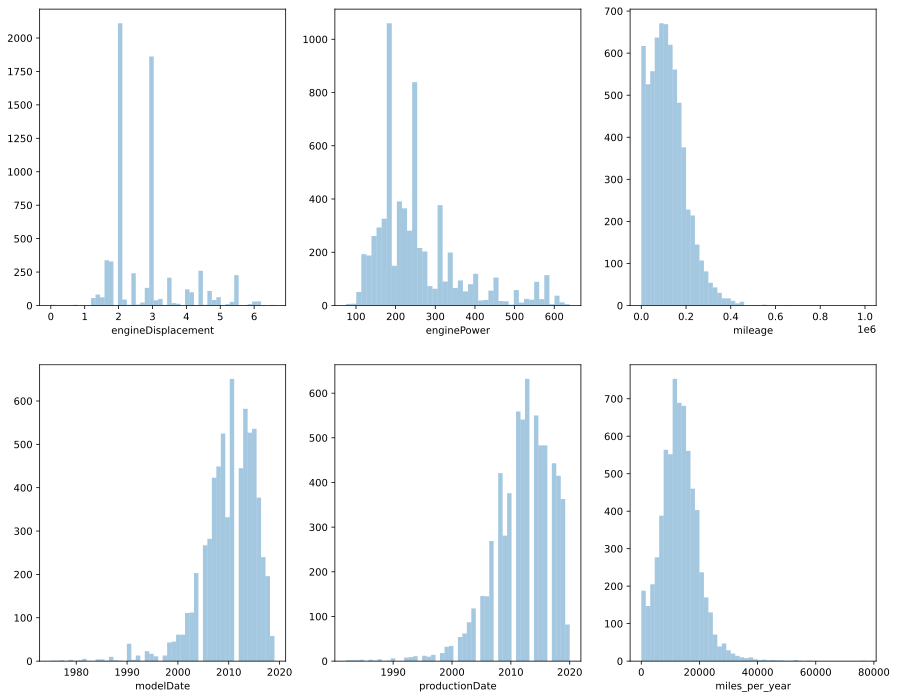

In [69]:
# Обозначим список
num_cols = ['engineDisplacement', 'enginePower','mileage', 'modelDate', 'productionDate', 'miles_per_year']

#Посмотрим распределение данных
fig, axes = plt.subplots(2,3, figsize=(15, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(ttrain[col], kde=False, ax=axes.flat[i])

In [70]:
# Удалим выбросы в числовых признаках
for col in ['engineDisplacement', 'enginePower','mileage']:
    d = outliers_iqr(ttrain[col])
    ttrain = ttrain.loc[ttrain[col].between(d[0], d[1])]
    
# прологарифмируем целевую переменную
for col in ['enginePower', 'price']:
    ttrain[col] = np.log(ttrain[col] + 1)

C:\Users\assem\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


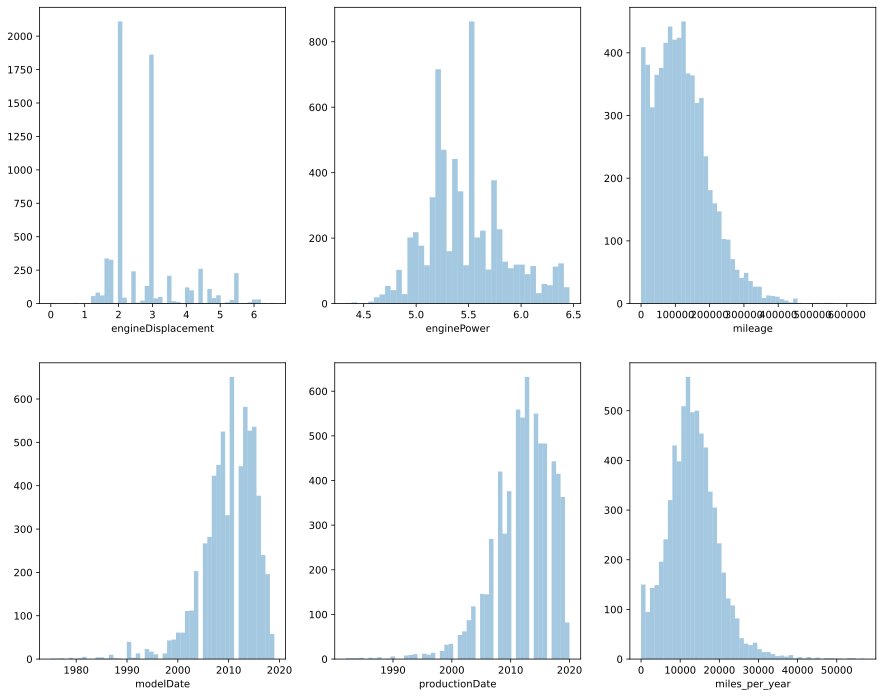

In [71]:
#Посмотрим распределение данных
fig, axes = plt.subplots(2,3, figsize=(15, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(ttrain[col], kde=False, ax=axes.flat[i])

In [72]:
len(ttrain)

6681

# Нормализация и значимость данных

In [73]:
scaler = MinMaxScaler()
for column in num_cols:
    ttrain[column] = scaler.fit_transform(ttrain[[column]])[:,0]

<AxesSubplot:>

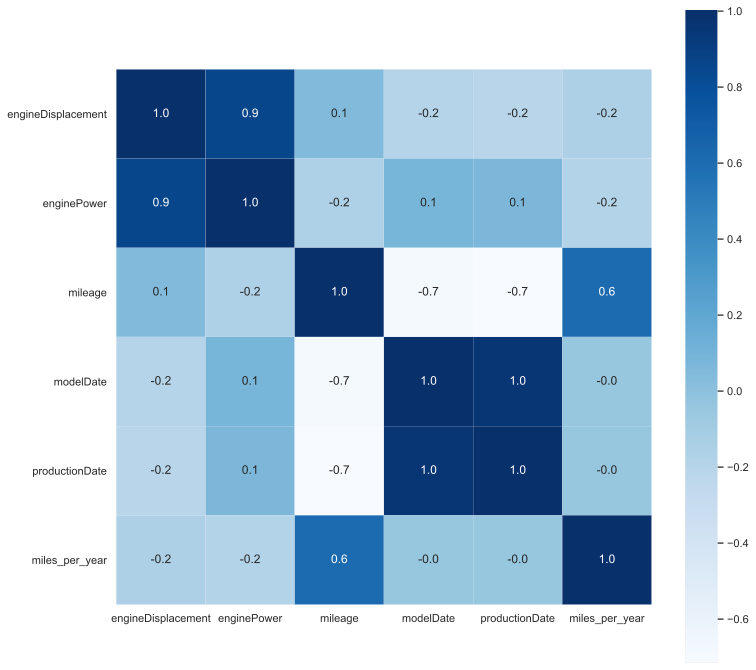

In [74]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(ttrain[num_cols].corr(),
            square=True,
            annot=True,
            fmt=".1f",
            linewidths=0.1,
            cmap="Blues")

Text(0.5, 0, 'F-value')

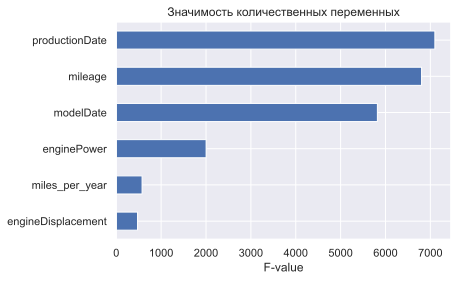

In [75]:
# для оценки непрерывных значений будем использовать функцию f_regression
imp_num = pd.Series(f_regression(ttrain[num_cols], ttrain['price'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость количественных переменных')
plt.xlabel('F-value')

In [76]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

In [77]:
for column in cat_cols:
    ttrain[column] = ttrain[column].astype('category').cat.codes

<AxesSubplot:>

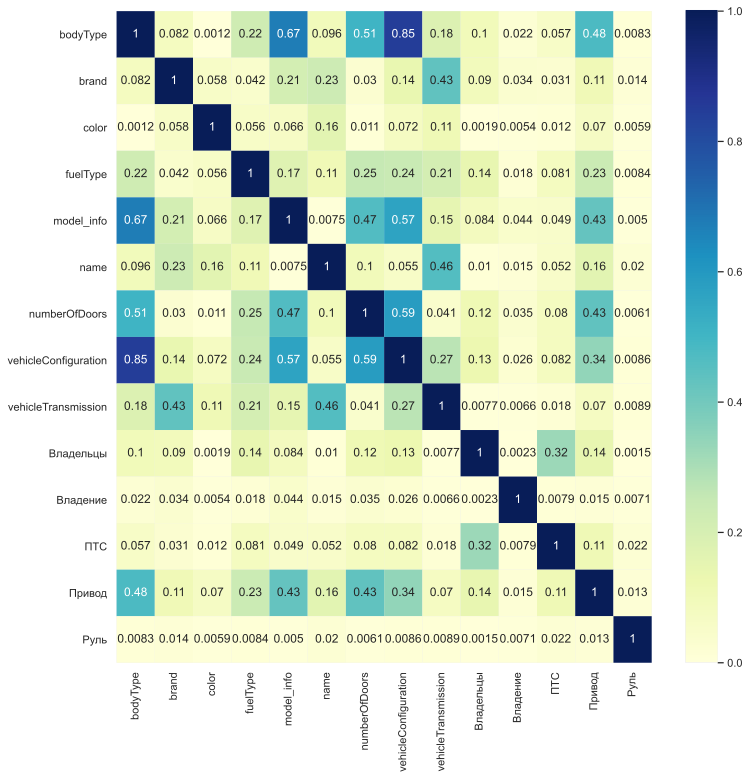

In [78]:
plt.subplots(figsize=(12, 12))
sns.heatmap(ttrain[cat_cols].corr(method='spearman').abs(),
            vmin=0,
            vmax=1,
            cmap="YlGnBu",
           annot=True)

Text(0.5, 1.0, 'Significance of cat variables')

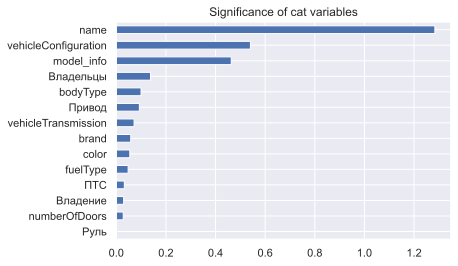

In [79]:
imp_cat = pd.Series(mutual_info_regression(ttrain[cat_cols],
                                        ttrain['price'],
                                        discrete_features=True),
                    index=ttrain[cat_cols].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

In [80]:
ttrain.drop(['sell_id', 'description'], axis = 1, inplace=True)

In [81]:
ttrain.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,4WD,miles_per_year,vehicle_age
0,12,1,15,0.454545,0.600140,0,0.375766,0.727273,7,670,2,13.303019,0.657895,201,0,2,116,1,2,0,1,0.306342,14
1,12,0,11,0.424242,0.465697,0,0.280674,0.818182,16,178,2,13.652993,0.763158,255,1,1,3,1,1,0,0,0.320346,10
2,12,2,15,0.530303,0.655227,0,0.188240,0.772727,36,463,2,14.096924,0.815789,205,0,2,116,1,2,0,1,0.268558,8
3,12,0,1,0.303030,0.407260,0,0.231594,0.818182,16,129,2,13.610945,0.763158,252,1,2,107,1,1,0,0,0.264328,10
4,8,0,1,0.272727,0.352306,0,0.214723,0.727273,15,20,3,13.604791,0.763158,150,1,2,107,1,1,0,0,0.245072,10


Кандидаты на удаление: enginePower, modelDate, bodyType  
Удаление коррелирующих столбцов негативно влияет на результат